# Clasificadores utilizando ML

- Utilizando redes neuronales (toca ver de cuál tipo, si recurrentes, convolucionales, etc.), aquí aplicaría las funciones de activación de ReLU, Sigmoide, tanh y Softmax
- Utilizando los arboles de decisión
- Utilizando bosques aleatorios
- Utilizando Extreme Gradient Boosting

Saldrían varios modelos, pero ahí ya tocaría ver cuál de todos dan mejores resultados, quizás calculando la métrica de F1 sirva para ver cuál nos da mejores resultados, quizás no, quizás bastaría solo calculando la precisión bastaría. ¡Me encantaría utilizar las matrices de confusión!

Falta implementar para que se pueda leer los archivos pickle

In [1]:
import pickle
import math
import tensorflow as tf
import keras_tuner as kt
import tensorflow.keras as keras  # type: ignore
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV


classes_dict = {'Neutral': 0, 'Calm': 1, 'Happy': 2, 'Sad': 3, 'Angry': 4, 'Fearful': 5, 'Disgust': 6, 'Surprised': 7}
classes = np.array(['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised'])
x_labels = np.array(['sampen', 'dfa', 'lyap_e1', 'lyap_e2', 'lyap_e3', 'lyap_e4'])

def convert_y(y: np.ndarray) -> np.ndarray:
	return np.array([classes_dict[emotion] for emotion in y])


def contar_aciertos(y_pred: np.ndarray, y_test: np.ndarray) -> dict:
	return {
		emotion: {emotion_i: sum(1 for yi1, yi2 in zip(y_pred, y_test) if yi1 == emotion and yi2 == emotion_i) for emotion_i in classes_dict}
		for emotion in classes_dict
	}


def save_model(model, path: str, is_pickle: bool = True) -> None:
	if is_pickle:
		with open(path, 'wb') as f:
			pickle.dump(model, f)


def read_model(path: str, is_pickle: bool = True) -> any:
	if is_pickle:
		with open(path, 'rb') as f:
			return pickle.load(f)


def plot_confusion_matrix(y_test: np.ndarray, y_pred: np.ndarray, labels: np.ndarray | None = None) -> np.ndarray:
	if labels is None:
		labels = ['', 'Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']
	
	cm = metrics.confusion_matrix(y_test, y_pred, normalize='true')
	fig, ax = plt.subplots(figsize=(8, 8))

	im = ax.imshow(cm, cmap=plt.cm.Blues)
	ax.figure.colorbar(im, ax=ax, pad=0.01, shrink=0.845)
	ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')

	plt.setp(ax.get_xticklabels(), rotation=15, size=10)
	plt.setp(ax.get_yticklabels(), rotation=25, size=10)

	fmt = '.2f'
	thresh = cm.max()/2.
	for i in range(cm.shape[0]):
		for j in range(cm.shape[1]):
			ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", size=10, color="white" if cm[i, j] > thresh else "black")

	plt.show()

	return cm

# Dividir los datos de entrenamiento y de testeo

In [4]:
# Prueba de concatenación de los archivos de info

display(pd.read_csv('data/resampled.csv', delimiter=';', index_col=0),
		pd.concat([
			pd.read_csv('data/info.csv', delimiter=';', index_col=0),
			pd.read_csv('data/original_info.csv', delimiter=';', index_col=0).drop('File', axis=1),
			pd.read_csv('data/original.csv', delimiter=';', index_col=0).drop('File', axis=1)
		], axis=1)
		)

,File,dfa,hurst,lyap_e1,lyap_e2,lyap_e3,lyap_e4,sampen
0,03-01-01-01-01-01-01.wav,0.525817,0.542769,0.194123,0.049047,-0.058278,-0.229855,0.002456
1,03-01-01-01-01-02-01.wav,0.543882,0.567168,0.202827,0.054279,-0.055131,-0.230131,0.003267
2,03-01-01-01-02-01-01.wav,0.497989,0.555005,0.206760,0.053725,-0.055660,-0.232098,0.001718
3,03-01-01-01-02-02-01.wav,0.528658,0.541704,0.210337,0.060357,-0.052299,-0.225092,0.002590
4,03-01-02-01-01-01-01.wav,0.537013,0.529767,0.202102,0.052980,-0.056396,-0.233067,0.005414
...,...,...,...,...,...,...,...,...
1435,03-01-08-01-02-02-24.wav,0.279378,0.287826,0.125982,0.032494,-0.050994,-0.194993,0.001191
1436,03-01-08-02-01-01-24.wav,0.283507,0.403359,0.120869,0.030594,-0.050296,-0.193513,0.004023
1437,03-01-08-02-01-02-24.wav,0.279962,0.326540,0.110139,0.024464,-0.050575,-0.190796,0.003648
1438,03-01-08-02-02-01-24.wav,0.344202,0.593980,0.099007,0.023812,-0.049864,-0.184661,0.004206


,Actor,Sex,Emotion,Intensity,Statement,Reps,File,Duration,No. Samples,Sample Rate,dfa,hurst,lyap_e1,lyap_e2,lyap_e3,lyap_e4,sampen
0,Actor_01,Man,Neutral,Normal,Kids are talking by the door,1,03-01-01-01-01-01-01.wav,3.303311,72838,22050.0,0.647347,0.662742,0.155715,0.041440,-0.044557,-0.189358,0.003430
1,Actor_01,Man,Neutral,Normal,Kids are talking by the door,2,03-01-01-01-01-02-01.wav,3.336689,73574,22050.0,0.665174,0.679229,0.163192,0.044047,-0.043396,-0.191906,0.004192
2,Actor_01,Man,Neutral,Normal,Dogs are sitting by the door,1,03-01-01-01-02-01-01.wav,3.269932,72102,22050.0,0.614524,0.659253,0.168320,0.045530,-0.044717,-0.191442,0.002442
3,Actor_01,Man,Neutral,Normal,Dogs are sitting by the door,2,03-01-01-01-02-02-01.wav,3.169841,69895,22050.0,0.660613,0.672091,0.181301,0.049826,-0.043994,-0.195651,0.002787
4,Actor_01,Man,Calm,Normal,Kids are talking by the door,1,03-01-02-01-01-01-01.wav,3.536871,77988,22050.0,0.672031,0.635130,0.162119,0.043490,-0.045780,-0.193419,0.005565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,Actor_24,Woman,Surprised,Normal,Dogs are sitting by the door,2,03-01-08-01-02-02-24.wav,3.403401,75045,22050.0,0.404452,0.336002,0.144672,0.039770,-0.043887,-0.187583,0.001683
1436,Actor_24,Woman,Surprised,Strong,Kids are talking by the door,1,03-01-08-02-01-01-24.wav,3.937279,86817,22050.0,0.397528,0.429025,0.135400,0.037677,-0.045062,-0.190716,0.005638
1437,Actor_24,Woman,Surprised,Strong,Kids are talking by the door,2,03-01-08-02-01-02-24.wav,3.970658,87553,22050.0,0.391202,0.339084,0.132568,0.037252,-0.044122,-0.183498,0.005089
1438,Actor_24,Woman,Surprised,Strong,Dogs are sitting by the door,1,03-01-08-02-02-01-24.wav,3.670340,80931,22050.0,0.436130,0.595168,0.117584,0.032154,-0.045620,-0.183241,0.005203


In [5]:
info = pd.read_csv('data/info.csv', delimiter=';', index_col=0)
original = pd.read_csv('data/original.csv', delimiter=';', index_col=0)

df_data = pd.concat([info, original.drop('File', axis=1)], axis=1)

display(df_data.describe())

df_data.drop(['Actor', 'File', 'Sex', 'Intensity', 'Statement', 'Reps', 'Duration'], axis=1, inplace=True)

x = df_data[x_labels].to_numpy()
y = df_data['Emotion'].to_numpy()

display(x, y)

,Reps,Duration,dfa,hurst,lyap_e1,lyap_e2,lyap_e3,lyap_e4,sampen
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,1.500000,3.700688,0.573472,0.596939,0.140240,0.038394,-0.044068,-0.186602,0.004900
std,0.500174,0.336676,0.134657,0.170681,0.019923,0.006857,0.002571,0.005527,0.002252
min,1.000000,2.936281,0.246752,0.258255,0.080217,0.014620,-0.052520,-0.204695,0.001222
25%,1.000000,3.470159,0.480207,0.446462,0.125504,0.033562,-0.045657,-0.190396,0.003330
50%,1.500000,3.670340,0.555962,0.590647,0.140832,0.038980,-0.043859,-0.186972,0.004502
75%,2.000000,3.870567,0.647182,0.763400,0.155649,0.043490,-0.042295,-0.182892,0.005827
max,2.000000,5.271973,1.160343,0.906782,0.211617,0.061741,-0.036791,-0.165578,0.022572


array([[ 0.00343007,  0.64734745,  0.15571544,  0.04143977, -0.04455741,
        -0.18935844],
       [ 0.00419243,  0.66517377,  0.16319233,  0.04404667, -0.04339594,
        -0.19190563],
       [ 0.0024424 ,  0.6145238 ,  0.16831964,  0.04553036, -0.0447175 ,
        -0.19144209],
       ...,
       [ 0.00508927,  0.391202  ,  0.13256754,  0.03725165, -0.04412238,
        -0.1834979 ],
       [ 0.00520276,  0.43612957,  0.1175843 ,  0.03215419, -0.04562034,
        -0.18324137],
       [ 0.00274624,  0.47817472,  0.12523158,  0.03197647, -0.04671308,
        -0.18693548]])

array(['Neutral', 'Neutral', 'Neutral', ..., 'Surprised', 'Surprised',
       'Surprised'], dtype=object)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f'x_train = {x_train} - {x_train.shape}\n')
print(f'y_train = {y_train} - {y_train.shape}\n')
print(f'x_test = {x_test} - {x_test.shape}\n')
print(f'y_test = {y_test} - {y_test.shape}')

x_train = [[ 0.0053082   0.59509856  0.17065512  0.04729957 -0.0448296  -0.19360566]
 [ 0.00216     0.8550463   0.11860645  0.03188637 -0.04289417 -0.17743877]
 [ 0.00469769  0.4077468   0.12513219  0.03442714 -0.04530954 -0.18259864]
 ...
 [ 0.00531497  0.38804477  0.1452496   0.04218148 -0.0427533  -0.18556249]
 [ 0.00776729  0.6575448   0.14424486  0.03873167 -0.0450552  -0.18500976]
 [ 0.00843281  0.5906251   0.13778435  0.03930649 -0.04340959 -0.18885545]] - (1152, 6)

y_train = ['Calm' 'Happy' 'Fearful' ... 'Angry' 'Sad' 'Disgust'] - (1152,)

x_test = [[ 0.00856525  0.535616    0.14974305  0.04710238 -0.03851286 -0.18703257]
 [ 0.00483571  0.84518605  0.12411776  0.02915671 -0.04827366 -0.18684223]
 [ 0.00445098  0.5715651   0.11647926  0.03426862 -0.04085118 -0.17869586]
 ...
 [ 0.00557447  0.42439026  0.1666854   0.04909015 -0.04204057 -0.19070385]
 [ 0.00546986  0.6814685   0.14821029  0.04286956 -0.04245832 -0.18455355]
 [ 0.00483511  0.66930306  0.16361023  0.04359089 -0.044

# Modelo 1. Árboles de decisión

## Manual

In [378]:
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=80)
dtree = dtree.fit(x_train, y_train)

dtree

DecisionTreeClassifier(criterion='entropy', max_depth=80)

In [379]:
y_pred_dt = dtree.predict(x_test)
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_dt)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred_dt, average=None, labels=classes)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred_dt, average=None, labels=classes)}')
print(f'F1-score: {metrics.f1_score(y_test, y_pred_dt, average=None, labels=classes)}')

Accuracy: 0.2604166666666667
Precison: [0.10714286 0.32258065 0.13888889 0.17241379 0.35416667 0.29411765
 0.175      0.42857143]
Recall: [0.15       0.22727273 0.14705882 0.12820513 0.4047619  0.3125
 0.21875    0.4       ]
F1-score: [0.125      0.26666667 0.14285714 0.14705882 0.37777778 0.3030303
 0.19444444 0.4137931 ]


In [385]:
save_model(dtree, 'models/dtree1.pickle')

In [382]:
display(metrics.confusion_matrix(y_test, y_pred_dt), contar_aciertos(y_pred_dt, y_test))

array([[17,  1, 11,  3,  4,  3,  1,  2],
       [ 4, 10,  6,  2,  5,  6, 10,  1],
       [ 3,  3,  7,  4,  3,  2,  5,  5],
       [ 8,  2,  1, 10,  5,  2,  2,  2],
       [ 8,  2,  3,  5,  5,  3,  1,  7],
       [ 0,  5,  1,  2,  2,  3,  3,  4],
       [ 5,  6, 10,  3,  3,  4,  5,  3],
       [ 3,  2,  1,  5,  9,  5,  2, 18]], dtype=int64)

{'Neutral': {'Neutral': 3,
  'Calm': 6,
  'Happy': 3,
  'Sad': 4,
  'Angry': 3,
  'Fearful': 2,
  'Disgust': 2,
  'Surprised': 5},
 'Calm': {'Neutral': 5,
  'Calm': 10,
  'Happy': 2,
  'Sad': 6,
  'Angry': 1,
  'Fearful': 2,
  'Disgust': 3,
  'Surprised': 2},
 'Happy': {'Neutral': 2,
  'Calm': 5,
  'Happy': 5,
  'Sad': 3,
  'Angry': 4,
  'Fearful': 5,
  'Disgust': 3,
  'Surprised': 9},
 'Sad': {'Neutral': 3,
  'Calm': 10,
  'Happy': 1,
  'Sad': 5,
  'Angry': 1,
  'Fearful': 2,
  'Disgust': 5,
  'Surprised': 2},
 'Angry': {'Neutral': 0,
  'Calm': 4,
  'Happy': 8,
  'Sad': 5,
  'Angry': 17,
  'Fearful': 8,
  'Disgust': 3,
  'Surprised': 3},
 'Fearful': {'Neutral': 2,
  'Calm': 2,
  'Happy': 5,
  'Sad': 3,
  'Angry': 3,
  'Fearful': 10,
  'Disgust': 4,
  'Surprised': 5},
 'Disgust': {'Neutral': 1,
  'Calm': 6,
  'Happy': 3,
  'Sad': 10,
  'Angry': 11,
  'Fearful': 1,
  'Disgust': 7,
  'Surprised': 1},
 'Surprised': {'Neutral': 4,
  'Calm': 1,
  'Happy': 7,
  'Sad': 3,
  'Angry': 2,
  'Fea

C:\Users\JuanD\AppData\Local\Temp\ipykernel_28348\703231798.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')
C:\Users\JuanD\AppData\Local\Temp\ipykernel_28348\703231798.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')


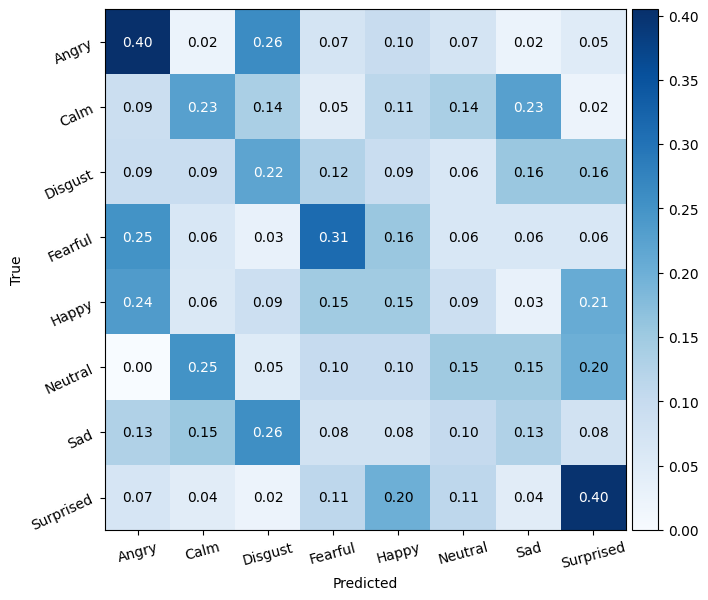

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [381]:
cm1 = plot_confusion_matrix(y_test, y_pred_dt)
cm1.sum(1)

## RandomizedSearchCV

In [68]:
param_dist = {'max_depth': randint(1, 200)}

rand_search = RandomizedSearchCV(DecisionTreeClassifier(), param_dist, n_iter=10, cv=5)
rand_search.fit(x_train, y_train)

best_dtree1 = rand_search.best_estimator_
print(f'Mejores hiperparametros: {rand_search.best_params_}')

Mejores hiperparametros: {'max_depth': 8}


In [69]:
y_pred_dt1 = best_dtree1.predict(x_test)
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_dt1)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred_dt1, average=None, labels=classes)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred_dt1, average=None, labels=classes)}')
print(f'F1-score: {metrics.f1_score(y_test, y_pred_dt1, average=None, labels=classes)}')

Accuracy: 0.2951388888888889
Precision: [0.14285714 0.28       0.20588235 0.125      0.38       0.25581395
 0.22580645 0.53125   ]
Recall: [0.05       0.47727273 0.20588235 0.05128205 0.45238095 0.34375
 0.21875    0.37777778]
F1-score: [0.07407407 0.35294118 0.20588235 0.07272727 0.41304348 0.29333333
 0.22222222 0.44155844]


In [70]:
save_model(best_dtree1, 'models/dtree2.pickle')

C:\Users\JuanD\AppData\Local\Temp\ipykernel_23532\844696108.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')
C:\Users\JuanD\AppData\Local\Temp\ipykernel_23532\844696108.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')


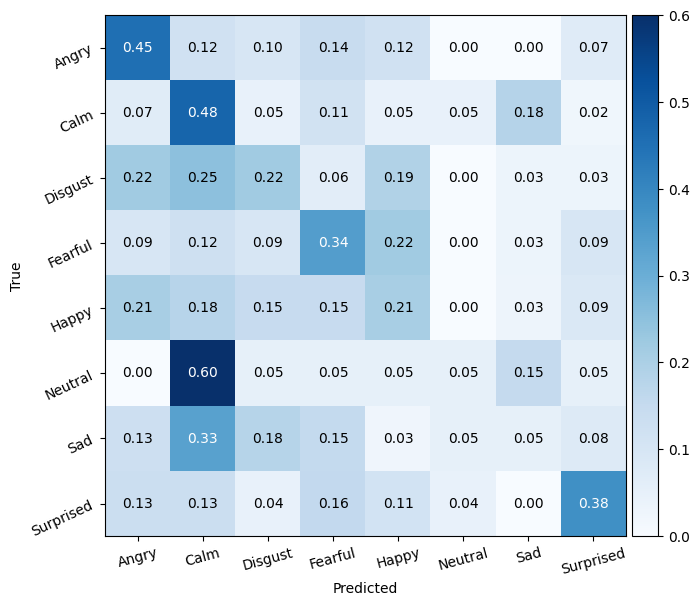

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [71]:
cm2 = plot_confusion_matrix(y_test, y_pred_dt1)
cm2.sum(1)

## GridSearchCV

In [62]:
param_dist = {'max_depth': [x for x in range(1, 500+1)]}

rand_search = GridSearchCV(DecisionTreeClassifier(), param_dist, cv=5)
rand_search.fit(x_train, y_train)

best_dtree2 = rand_search.best_estimator_
print(f'Mejores hiperparametros: {rand_search.best_params_}')

Mejores hiperparametros: {'max_depth': 6}


In [63]:
y_pred_dt2 = best_dtree2.predict(x_test)
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_dt2)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred_dt2, average=None, labels=classes)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred_dt2, average=None, labels=classes)}')
print(f'F1-score: {metrics.f1_score(y_test, y_pred_dt2, average=None, labels=classes)}')

Accuracy: 0.2847222222222222
Precision: [0.         0.33962264 0.23809524 0.         0.37037037 0.18055556
 0.25641026 0.47058824]
Recall: [0.         0.40909091 0.14705882 0.         0.47619048 0.40625
 0.3125     0.35555556]
F1-score: [0.         0.37113402 0.18181818 0.         0.41666667 0.25
 0.28169014 0.40506329]


In [2]:
save_model(best_dtree2, 'models/dtree3.pickle')

NameError: name 'best_dtree2' is not defined

C:\Users\JuanD\AppData\Local\Temp\ipykernel_23532\844696108.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')
C:\Users\JuanD\AppData\Local\Temp\ipykernel_23532\844696108.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')


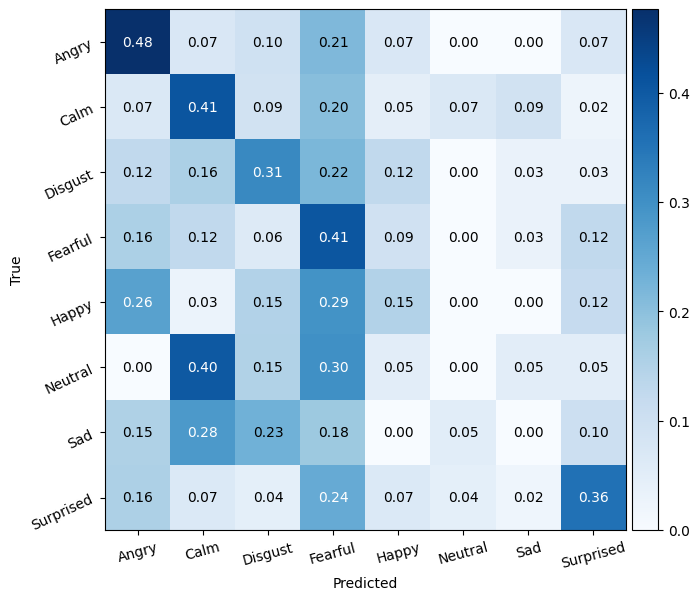

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
cm3 = plot_confusion_matrix(y_test, y_pred_dt2)
cm3.sum(1)

# Módelo 2. Bosques aleatorios

## Manual

In [389]:
rf = RandomForestClassifier(criterion='entropy', max_depth=80)
rf = rf.fit(x_train, y_train)
rf

RandomForestClassifier(criterion='entropy', max_depth=80)

In [390]:
y_pred_rf = rf.predict(x_test)
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_rf)}')
print(f'F1-score: {metrics.f1_score(y_test, y_pred_rf, average=None, labels=classes)}')

Accuracy: 0.3472222222222222
F1-score: [0.10526316 0.44       0.27692308 0.20289855 0.41975309 0.36923077
 0.26086957 0.49438202]


In [391]:
save_model(rf, 'models/rf1.pickle')

In [392]:
display(metrics.confusion_matrix(y_test, y_pred_rf), contar_aciertos(y_pred_rf, y_test))

array([[17,  3,  6,  3,  4,  1,  4,  4],
       [ 2, 22,  5,  3,  1,  3,  8,  0],
       [ 2,  2,  9,  1,  8,  2,  5,  3],
       [ 5,  2,  2, 12,  3,  2,  1,  5],
       [ 8,  1,  2,  4,  9,  2,  2,  6],
       [ 0, 10,  4,  0,  2,  2,  1,  1],
       [ 2, 11,  6,  5,  0,  5,  7,  3],
       [ 3,  5,  3,  5,  4,  1,  2, 22]], dtype=int64)

{'Neutral': {'Neutral': 2,
  'Calm': 3,
  'Happy': 2,
  'Sad': 5,
  'Angry': 1,
  'Fearful': 2,
  'Disgust': 2,
  'Surprised': 1},
 'Calm': {'Neutral': 10,
  'Calm': 22,
  'Happy': 1,
  'Sad': 11,
  'Angry': 3,
  'Fearful': 2,
  'Disgust': 2,
  'Surprised': 5},
 'Happy': {'Neutral': 2,
  'Calm': 1,
  'Happy': 9,
  'Sad': 0,
  'Angry': 4,
  'Fearful': 3,
  'Disgust': 8,
  'Surprised': 4},
 'Sad': {'Neutral': 1,
  'Calm': 8,
  'Happy': 2,
  'Sad': 7,
  'Angry': 4,
  'Fearful': 1,
  'Disgust': 5,
  'Surprised': 2},
 'Angry': {'Neutral': 0,
  'Calm': 2,
  'Happy': 8,
  'Sad': 2,
  'Angry': 17,
  'Fearful': 5,
  'Disgust': 2,
  'Surprised': 3},
 'Fearful': {'Neutral': 0,
  'Calm': 3,
  'Happy': 4,
  'Sad': 5,
  'Angry': 3,
  'Fearful': 12,
  'Disgust': 1,
  'Surprised': 5},
 'Disgust': {'Neutral': 4,
  'Calm': 5,
  'Happy': 2,
  'Sad': 6,
  'Angry': 6,
  'Fearful': 2,
  'Disgust': 9,
  'Surprised': 3},
 'Surprised': {'Neutral': 1,
  'Calm': 0,
  'Happy': 6,
  'Sad': 3,
  'Angry': 4,
  'Fear

C:\Users\JuanD\AppData\Local\Temp\ipykernel_28348\787255951.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')
C:\Users\JuanD\AppData\Local\Temp\ipykernel_28348\787255951.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')


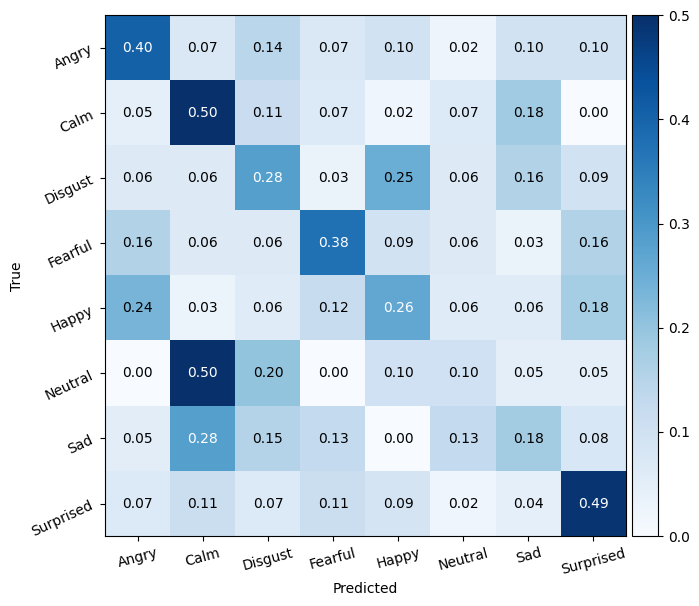

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [393]:
cm4 = plot_confusion_matrix(y_test, y_pred_rf)
cm4.sum(1)

## RandomizedSearchCV

In [101]:
param_dist = {'n_estimators': randint(50, 500),
              'max_depth': randint(1, 20)}

rand_search = RandomizedSearchCV(RandomForestClassifier(), param_dist, n_iter=5, cv=5)
rand_search.fit(x_train, y_train)

best_rf1 = rand_search.best_estimator_
print(f'Mejores hiperparametros: {rand_search.best_params_}')

Mejores hiperparametros: {'max_depth': 11, 'n_estimators': 478}


In [13]:
best_rf1 = read_model('models/rf1.pickle')

In [14]:
y_pred_rf1 = best_rf1.predict(x_test)
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_rf1)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred_rf1, average=None, labels=classes)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred_rf1, average=None, labels=classes)}')
print(f'F1-score: {metrics.f1_score(y_test, y_pred_rf1, average=None, labels=classes)}')

Accuracy: 0.3472222222222222
Precision: [0.11111111 0.39285714 0.29032258 0.23333333 0.43589744 0.36363636
 0.24324324 0.5       ]
Recall: [0.1        0.5        0.26470588 0.17948718 0.4047619  0.375
 0.28125    0.48888889]
F1-score: [0.10526316 0.44       0.27692308 0.20289855 0.41975309 0.36923077
 0.26086957 0.49438202]


In [407]:
save_model(best_rf1, 'models/rf2.pickle')

C:\Users\JuanD\AppData\Local\Temp\ipykernel_15872\2412610735.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')
C:\Users\JuanD\AppData\Local\Temp\ipykernel_15872\2412610735.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')


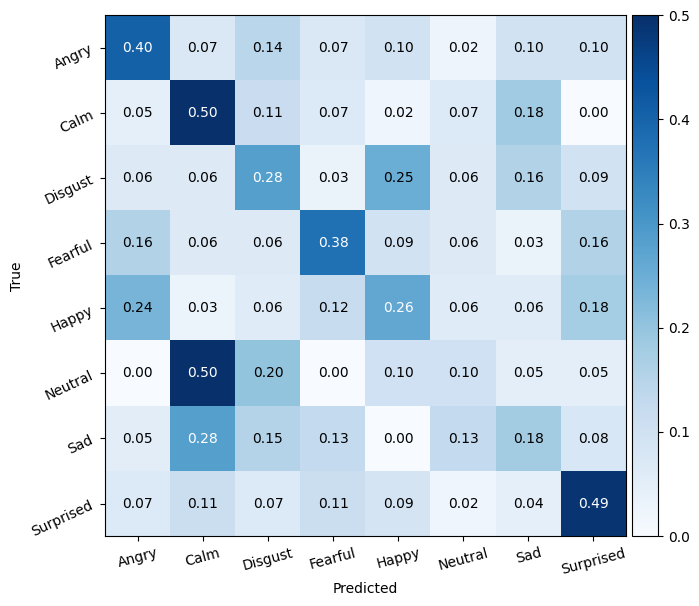

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [19]:
cm5 = plot_confusion_matrix(y_test, y_pred_rf1)
cm5.sum(1)

## GridSearchCV

In [39]:
# Hpcha... 313 minutos y 50.7 segundos
param_dist = {'n_estimators': [x for x in range(50, 500+1)],
              'max_depth': [x for x in range(1, 20)]}

rand_search = GridSearchCV(RandomForestClassifier(), param_dist, cv=5)
rand_search.fit(x_train, y_train)

best_rf2 = rand_search.best_estimator_
print(f'Mejores hiperparametros: {rand_search.best_params_}')

Mejores hiperparametros: {'max_depth': 8, 'n_estimators': 306}


In [15]:
best_rf2 = read_model('models/rf2.pickle')

In [17]:
y_pred_rf2 = best_rf2.predict(x_test)
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred_rf2)}')
print(f'Precision: {metrics.precision_score(y_test, y_pred_rf2, average=None, labels=classes)}')
print(f'Recall: {metrics.recall_score(y_test, y_pred_rf2, average=None, labels=classes)}')
print(f'F1-score: {metrics.f1_score(y_test, y_pred_rf2, average=None, labels=classes)}')

Accuracy: 0.3576388888888889
Precision: [0.08333333 0.36231884 0.26315789 0.25       0.48648649 0.375
 0.29032258 0.46938776]
Recall: [0.05       0.56818182 0.29411765 0.12820513 0.42857143 0.375
 0.28125    0.51111111]
F1-score: [0.0625     0.44247788 0.27777778 0.16949153 0.4556962  0.375
 0.28571429 0.4893617 ]


In [41]:
save_model(best_rf2, 'models/rf3.pickle')

C:\Users\JuanD\AppData\Local\Temp\ipykernel_15872\2412610735.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')
C:\Users\JuanD\AppData\Local\Temp\ipykernel_15872\2412610735.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=labels, yticklabels=labels, ylabel='True', xlabel='Predicted')


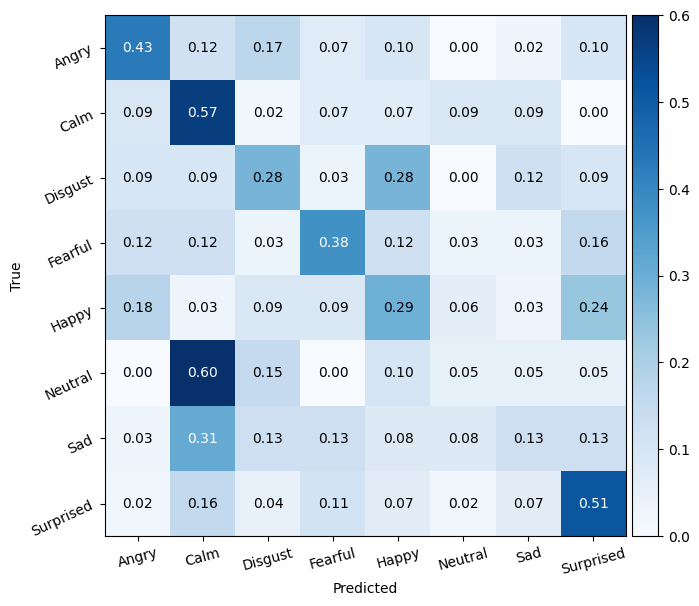

array([1., 1., 1., 1., 1., 1., 1., 1.])

In [18]:
cm6 = plot_confusion_matrix(y_test, y_pred_rf2)
cm6.sum(1)

# Módelo 3. Redes neuronales

De aquí salen otros submodelos utilizando las funciones de activaciones tanh, sigmoide y ReLU. Además

In [8]:
batch_size = 32
num_train = len(x_train)
num_cols = len(x_labels)
num_classes = len(classes_dict)

y_train = convert_y(y_train)
y_test = convert_y(y_test)

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(num_train).batch(batch_size).prefetch(5)

## Manual

In [12]:
model: keras.Sequential = keras.Sequential([
	keras.layers.Dense(units=10, input_shape=[num_cols], activation='relu'),
	keras.layers.Dense(units=20, activation='relu'),
	keras.layers.Dense(units=20, activation='relu'),
	keras.layers.Dense(units=num_classes, activation='softmax')
])

model.compile(
	optimizer='adam',
	loss=keras.losses.SparseCategoricalCrossentropy(),
	metrics=['accuracy']
)

C:\Users\JuanD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
history = model.fit(train_data, epochs=60, steps_per_epoch=math.ceil(num_train/batch_size))

Epoch 1/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 686us/step - accuracy: 0.1271 - loss: 2.0776 
Epoch 2/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.1309 - loss: 2.0718
Epoch 3/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.1297 - loss: 2.0656
Epoch 4/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.1363 - loss: 2.0640
Epoch 5/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.1370 - loss: 2.0601
Epoch 6/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.1209 - loss: 2.0704
Epoch 7/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.1254 - loss: 2.0553
Epoch 8/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.1486 - loss: 2.0500
Epoch 9/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.1088 - loss: 2.0642
Epoch 10/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.1890 - loss: 2.0478
Epoch 11/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.1040 - loss: 2.0577
Epoch 12/60
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/ste

Ya no quiero seguir... :C  
JAJAJJAJA QUE PORQUERÍA XD

## KerasTuner

In [46]:
def build_model(hp) -> any:
	hp_units1, hp_units2, hp_units3  = [hp.Int(f'units{x}', min_value=50, max_value=500, step=10) for x in range(1, 4)]
	hp_activation1, hp_activation2, hp_activation3 = [hp.Choice(f'activation{x}', values=['relu', 'sigmoid', 'tanh']) for x in range(1, 4)]

	model: keras.Sequential = keras.Sequential([
		keras.layers.Dense(units=hp_units1, activation=hp_activation1, input_shape=[num_cols]),
		keras.layers.Dense(units=hp_units2, activation=hp_activation2),
		keras.layers.Dense(units=hp_units3, activation=hp_activation3),
		keras.layers.Dense(units=num_classes, activation='softmax')
	])

	hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.003, 0.01, 0.03])
	model.compile(
		optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
		loss=keras.losses.SparseCategoricalCrossentropy(),
		metrics=['accuracy']
	)

	return model


In [47]:
tuner = kt.Hyperband(
	build_model,
	objective='val_accuracy',
	max_epochs=50,
	factor=3,
	project_name='best_neuronal_network_hyperband'
)

tuner.search(x_train, y_train, epochs=50, validation_split=0.2)
best_nn1 = tuner.get_best_models(num_models=1)[0]


Trial 90 Complete [00h 00m 08s]
val_accuracy: 0.17748917639255524

Best val_accuracy So Far: 0.2467532455921173
Total elapsed time: 00h 06m 36s


In [48]:
best_hp1 = tuner.get_best_hyperparameters(1)[0]
print(f"""Best units: 
	  1. {best_hp1.get('units1')}
	  2. {best_hp1.get('units2')}
	  3. {best_hp1.get('units3')}
Best activation:
	1. {best_hp1.get('activation1')}
	2. {best_hp1.get('activation2')}
	3. {best_hp1.get('activation3')}
Best learning rate: {best_hp1.get('learning_rate')}""")

Best units: 
	  1. 350
	  2. 340
	  3. 200
Best activation:
	1. tanh
	2. tanh
	3. sigmoid
Best learning rate: 0.003


In [49]:
best_nn1.save('models/nn1.h5')

In [50]:
tuner = kt.BayesianOptimization(
	build_model,
	objective='val_accuracy',
	max_trials=50,
	project_name='best_neuronal_network_bayessian'
)

tuner.search(x_train, y_train, epochs=50, validation_split=0.2)
best_nn2 = tuner.get_best_models(num_models=1)[0]


Trial 50 Complete [00h 00m 08s]
val_accuracy: 0.22510822117328644

Best val_accuracy So Far: 0.26406925916671753
Total elapsed time: 00h 06m 54s


C:\Users\JuanD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [51]:
best_hp2 = tuner.get_best_hyperparameters(1)[0]
print(f"""Best units:
	1. {best_hp2.get('units1')}
	2. {best_hp2.get('units2')}
	3. {best_hp2.get('units3')}
Best activation:
	1. {best_hp2.get('activation1')}
	2. {best_hp2.get('activation2')}
	3. {best_hp2.get('activation3')}
Best learning rate: {best_hp2.get('learning_rate')}""")

Best units:
	1. 360
	2. 170
	3. 250
Best activation:
	1. tanh
	2. tanh
	3. sigmoid
Best learning rate: 0.003


In [52]:
best_nn2.save('models/nn2.h5')

# Módelo 4. Extreme Gradient Boosting

In [5]:
print(randint(1, 200))